In [3]:
%config Completer.use_jedi = False

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

mutation_arange = [np.round(x,2) for x in np.arange(0.1,1,0.2)]


startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

In [22]:
    
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_plot2(data,variable_field,between_fields,path=None,save=False):
    fig,ax = plt.subplots(1,1,figsize=(15,15))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df.where(summary_df.reject == True,inplace=True)
    summary_df.dropna(inplace=True)
  
    
    optimal_params = extractOptimalParameters2(data,summary_df,1)
    if len(optimal_params) > 0:
        
        optimal_group = int(optimal_params.head(1)[between_fields]) or None
    else:
        optimal_group = None
    tukey.plot_simultaneous(figsize=(15,15),ax=ax,comparison_name =optimal_group )
    ax.set_xlabel(variable_field,fontsize=24)
    ax.set_ylabel("Parameter Group",fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.title("")
    plt.show()
    
    
    
    return summary_df ,fig, tukey
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov
def extractOptimalParameters2(resultsDataFrame,tukeyResult,amount=5):
    optimalParamGroups = tukeyResult.sort_values(by='meandiff').head(amount).group2
    resultDF = pd.DataFrame(columns=resultsDataFrame.columns)
    for group in optimalParamGroups:
        resultDF = pd.concat([resultDF,(resultsDataFrame.where(resultsDataFrame["Parameter Group"] == np.float(group))).dropna()],axis=0)
    return resultDF


# SA

In [6]:
SA_25_2 = pd.read_csv("parameter_data/UK25_2/SA.csv")
SA_25_4 = pd.read_csv("parameter_data/UK25_4/SA.csv")
SA_25_8 = pd.read_csv("parameter_data/UK25_8/SA.csv")
SA_50_1 = pd.read_csv("parameter_data/UK50_1/SA.csv")
SA_50_2 = pd.read_csv("parameter_data/UK50_2/SA.csv")
SA_50_4 = pd.read_csv("parameter_data/UK50_4/SA.csv")
SA_75_1 = pd.read_csv("parameter_data/UK75_1/SA.csv")
SA_75_3 = pd.read_csv("parameter_data/UK75_3/SA.csv")
SA_75_6 = pd.read_csv("parameter_data/UK75_6/SA.csv")





SA_25_2 = remove_unwanted_mutation_parameter_groups(SA_25_2)
SA_25_2["Parameter Group"] =SA_25_2["Parameter Group"]/2
combined_SA = [SA_25_2,SA_25_4,SA_25_8,SA_50_1,SA_50_2,SA_50_4,SA_75_1,SA_75_3,SA_75_6]


for df in combined_SA:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
SA_data = pd.concat(combined_SA)
    

In [54]:
datasetNames = ["UK25_2","UK25_4","UK25_8","UK50_1","SA_50_2","SA_50_4","UK75_1","UK75_3","UK75_6"]
optimal_params_SA=pd.DataFrame()
for dataframe,datasetName in zip(combined_SA,datasetNames):
    dataframe_optimal = dataframe.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin_minmax"]).head(1)
    dataframe_optimal["dataset"] = datasetName
    optimal_params_SA = pd.concat([optimal_params_SA,dataframe_optimal])
    
optimal_params_SA

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax,dataset
Parameter Group,,,,,,,,
3.0,14.5,86.633271,140.506111,0.7,165.322624,0.306996,0.119296,UK25_2
3.0,14.5,244.868543,364.809444,0.7,439.445288,0.196697,0.094512,UK25_4
2.0,14.5,108.992845,233.645556,0.5,258.218305,0.203475,0.466620,UK25_8
4.0,14.5,226.218534,219.179444,0.9,315.201768,0.211321,0.147638,UK50_1
4.0,14.5,176.402670,233.542778,0.9,292.791280,0.184953,0.145488,SA_50_2
3.0,14.5,185.473650,223.341111,0.7,290.449630,0.388152,0.198938,SA_50_4
3.0,14.5,435.895943,444.380556,0.7,622.761959,0.160460,0.151307,UK75_1
3.0,14.5,254.078349,244.811667,0.7,352.871568,0.238663,0.161200,UK75_3
4.0,14.5,346.572826,296.427222,0.9,456.533574,0.185181,0.141916,UK75_6


In [35]:

def get_sorted_df(dataFrames):
    optimal_params_DF=pd.DataFrame()
    datasetNames = ["UK25_2","UK25_4","UK25_8","UK50_1","SA_50_2","SA_50_4","UK75_1","UK75_3","UK75_6"]
    for dataframe,datasetName in zip(dataFrames,datasetNames):
        
        dataframe_optimal = dataframe.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin_minmax"]).head(1)
        dataframe_optimal["dataset"] = datasetName
        optimal_params_DF = pd.concat([optimal_params_DF,dataframe_optimal])
    return optimal_params_DF#.groupby("Parameter Group").head()
    
optimal_params_SA = get_sorted_df(combined_SA)
optimal_params_SA

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax,dataset
Parameter Group,,,,,,,,
3.0,14.5,86.633271,140.506111,0.7,165.322624,0.306996,0.119296,UK25_2
3.0,14.5,244.868543,364.809444,0.7,439.445288,0.196697,0.094512,UK25_4
2.0,14.5,108.992845,233.645556,0.5,258.218305,0.203475,0.466620,UK25_8
4.0,14.5,226.218534,219.179444,0.9,315.201768,0.211321,0.147638,UK50_1
4.0,14.5,176.402670,233.542778,0.9,292.791280,0.184953,0.145488,SA_50_2
3.0,14.5,185.473650,223.341111,0.7,290.449630,0.388152,0.198938,SA_50_4
3.0,14.5,435.895943,444.380556,0.7,622.761959,0.160460,0.151307,UK75_1
3.0,14.5,254.078349,244.811667,0.7,352.871568,0.238663,0.161200,UK75_3
4.0,14.5,346.572826,296.427222,0.9,456.533574,0.185181,0.141916,UK75_6


In [55]:
SA_data.groupby("Parameter Group").mean().sort_values(by=["distance_to_origin_minmax"]).head(10)

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax
Parameter Group,,,,,,,
4.0,14.5,230.408973,267.017593,0.9,355.700610,0.242115,0.190065
3.0,14.5,230.634386,266.696235,0.7,355.661139,0.241289,0.191629
2.0,14.5,235.571731,269.142407,0.5,360.831952,0.284147,0.230590
1.0,14.5,241.760433,271.671173,0.3,367.294120,0.320624,0.297470
0.0,14.5,260.239945,284.393765,0.1,389.803775,0.474803,0.508080


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



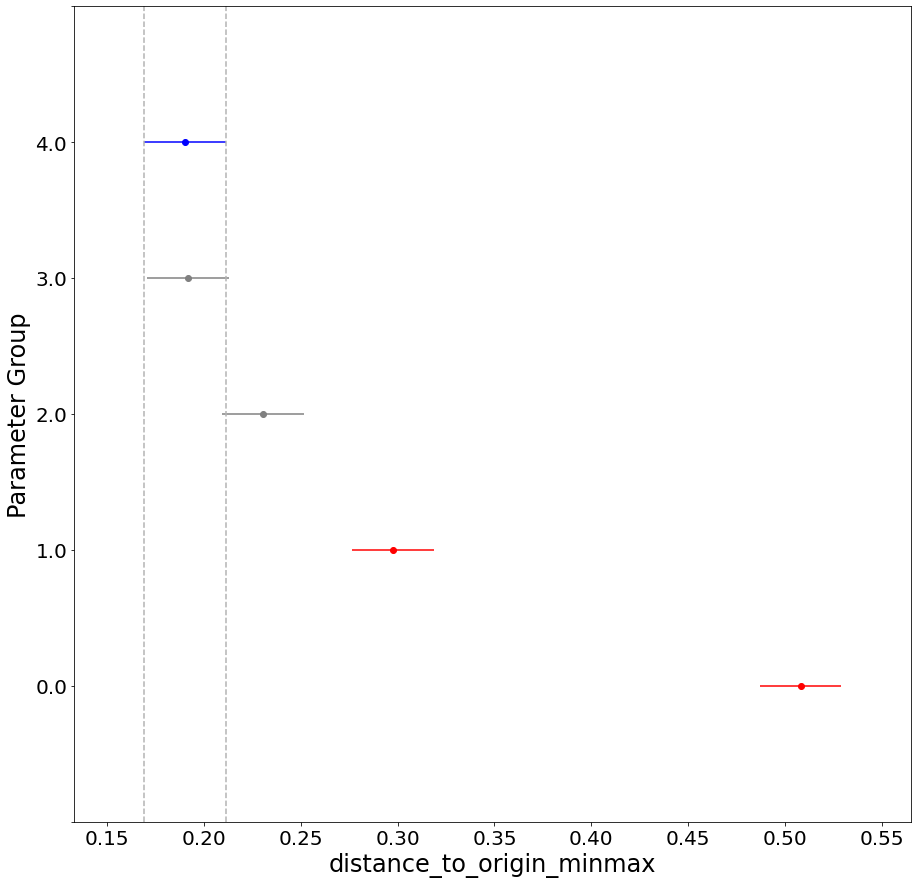

In [56]:
sa_data_tukey,fig,t = anova_plot2(SA_data,'distance_to_origin_minmax','Parameter Group')

# GA

In [18]:
GA_25_2 = pd.read_csv("parameter_data/UK25_2/GA.csv")
GA_25_4 = pd.read_csv("parameter_data/UK25_4/GA.csv")
GA_25_8 = pd.read_csv("parameter_data/UK25_8/GA.csv")
GA_50_1 = pd.read_csv("parameter_data/UK50_1/GA.csv")
GA_50_2 = pd.read_csv("parameter_data/UK50_2/GA.csv")
GA_50_4 = pd.read_csv("parameter_data/UK50_4/GA.csv")
GA_75_1 = pd.read_csv("parameter_data/UK75_1/GA.csv")
GA_75_3 = pd.read_csv("parameter_data/UK75_3/GA.csv")
GA_75_6 = pd.read_csv("parameter_data/UK75_6/GA.csv")



GA_25_2 = remove_unwanted_mutation_parameter_groups(GA_25_2)
GA_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_GA = [GA_25_2,GA_25_4,GA_25_8,GA_50_1,GA_50_2,GA_50_4,GA_75_1,GA_75_3,GA_75_6]

for df in combined_GA:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
GA_data = pd.concat(combined_GA)
    

In [19]:
optimal_params_GA = get_sorted_df(combined_GA)
optimal_params_GA

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax,dataset
Parameter Group,,,,,,,,,,
38.0,14.5,90.249107,133.971111,0.9,0.25,30.0,161.657528,0.305689,0.101789,UK25_2
37.0,14.5,244.499552,367.076111,0.9,0.25,20.0,441.161685,0.121666,0.070580,UK25_4
20.0,14.5,103.784878,238.100000,0.5,0.25,30.0,259.738873,0.077827,0.139958,UK25_8
34.0,14.5,221.017762,214.131111,0.7,0.75,20.0,307.867930,0.177583,0.086611,UK50_1
38.0,14.5,177.160847,232.666667,0.9,0.25,30.0,292.462853,0.121065,0.046868,SA_50_2
37.0,14.5,185.120894,221.627222,0.9,0.25,20.0,288.806637,0.254262,0.137391,SA_50_4
41.0,14.5,421.118672,444.985556,0.9,0.50,30.0,612.851684,0.120368,0.111188,UK75_1
38.0,14.5,250.293158,243.700000,0.9,0.25,30.0,349.364842,0.082722,0.037058,UK75_3
44.0,14.5,342.391580,299.158889,0.9,0.75,30.0,455.000961,0.107341,0.066648,UK75_6


In [45]:
GA_data.groupby("Parameter Group").mean().sort_values(by=["distance_to_origin_minmax"]).head(10)

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax
Parameter Group,,,,,,,,,
38.0,14.5,226.985353,266.567407,0.9,0.25,30.0,353.049486,0.154356,0.097026
41.0,14.5,227.307640,267.518333,0.9,0.50,30.0,353.954599,0.160740,0.104530
44.0,14.5,227.934922,267.722716,0.9,0.75,30.0,354.535114,0.161714,0.105678
37.0,14.5,227.509582,268.093395,0.9,0.25,20.0,354.642932,0.157305,0.106282
35.0,14.5,229.802546,268.116173,0.7,0.75,30.0,356.204789,0.164525,0.110389
28.0,14.5,229.249777,268.395802,0.7,0.25,20.0,356.011288,0.166447,0.111286
34.0,14.5,230.193058,267.983148,0.7,0.75,20.0,356.400763,0.169053,0.113788
29.0,14.5,228.768422,268.055802,0.7,0.25,30.0,355.581045,0.161592,0.115324
32.0,14.5,230.185978,268.185309,0.7,0.50,30.0,356.550837,0.175105,0.115523


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



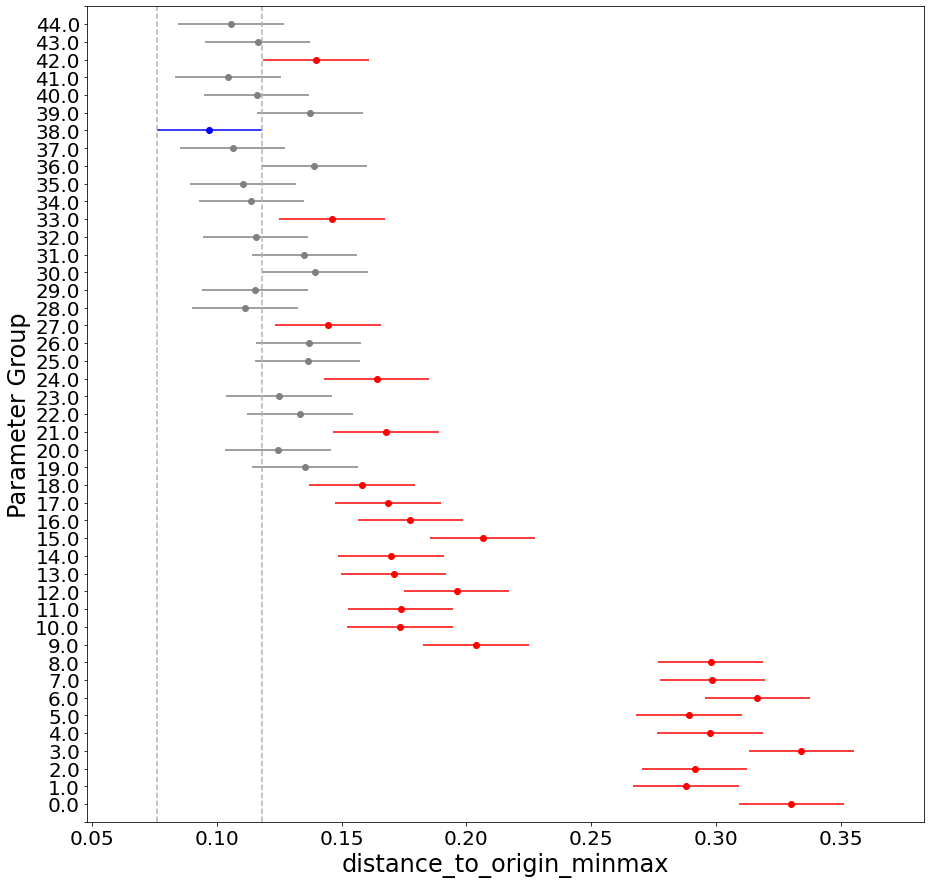

In [23]:
ga_data_tukey,fig,t = anova_plot2(GA_data,'distance_to_origin_minmax','Parameter Group')

# NSGAII

In [24]:
NSGA2_25_2 = pd.read_csv("parameter_data/UK25_2/NSGA2.csv")
NSGA2_25_4 = pd.read_csv("parameter_data/UK25_4/NSGA2.csv")
NSGA2_25_8 = pd.read_csv("parameter_data/UK25_8/NSGA2.csv")
NSGA2_50_1 = pd.read_csv("parameter_data/UK50_1/NSGA2.csv")
NSGA2_50_2 = pd.read_csv("parameter_data/UK50_2/NSGA2.csv")
NSGA2_50_4 = pd.read_csv("parameter_data/UK50_4/NSGA2.csv")
NSGA2_75_1 = pd.read_csv("parameter_data/UK75_1/NSGA2.csv")
NSGA2_75_3 = pd.read_csv("parameter_data/UK75_3/NSGA2.csv")
NSGA2_75_6 = pd.read_csv("parameter_data/UK75_6/NSGA2.csv")





NSGA2_25_2 = remove_unwanted_mutation_parameter_groups(NSGA2_25_2)
NSGA2_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_NSGA2 = [NSGA2_25_2,NSGA2_25_4,NSGA2_25_8,NSGA2_50_1,NSGA2_50_2,NSGA2_50_4,NSGA2_75_1,NSGA2_75_3,NSGA2_75_6]

for df in combined_NSGA2:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
NSGA2_data = pd.concat(combined_NSGA2)
    

In [27]:
optimal_params_NSGA2 = get_sorted_df(combined_NSGA2)
optimal_params_NSGA2

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax,dataset
Parameter Group,,,,,,,,,,
31.0,14.5,81.683863,172.013333,0.7,0.50,20.0,192.860254,0.315341,0.198649,UK25_2
30.0,14.5,247.573155,368.058333,0.7,0.50,10.0,443.774368,0.280963,0.082545,UK25_4
18.0,14.5,117.472232,241.004444,0.5,0.25,10.0,269.013437,0.322334,0.124183,UK25_8
41.0,14.5,221.441965,252.417778,0.9,0.50,30.0,338.541990,0.238795,0.205281,UK50_1
41.0,14.5,175.577513,259.845000,0.9,0.50,30.0,314.169952,0.118922,0.132283,SA_50_2
41.0,14.5,184.090173,239.059444,0.9,0.50,30.0,302.890944,0.144465,0.179455,SA_50_4
35.0,14.5,436.685245,443.914444,0.7,0.75,30.0,623.089503,0.139736,0.120668,UK75_1
44.0,14.5,241.130428,301.965556,0.9,0.75,30.0,388.355900,0.088393,0.217715,UK75_3
38.0,14.5,344.723065,319.607778,0.9,0.25,30.0,471.854091,0.163822,0.147238,UK75_6


In [46]:
NSGA2_data.groupby("Parameter Group").mean().sort_values(by=["distance_to_origin_minmax"]).head(10)

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax
Parameter Group,,,,,,,,,
41.0,14.5,226.915464,294.827654,0.9,0.50,30.0,376.591798,0.179195,0.183456
38.0,14.5,229.362163,295.453148,0.9,0.25,30.0,378.591201,0.194133,0.191871
44.0,14.5,227.825987,297.577840,0.9,0.75,30.0,379.610431,0.185619,0.197120
34.0,14.5,227.315238,297.550617,0.7,0.75,20.0,379.672920,0.175289,0.199029
31.0,14.5,227.949328,297.950123,0.7,0.50,20.0,379.700368,0.191410,0.199106
37.0,14.5,229.018704,297.450988,0.9,0.25,20.0,380.499838,0.187911,0.202501
29.0,14.5,229.264843,297.889691,0.7,0.25,30.0,380.899562,0.189764,0.203557
40.0,14.5,225.792717,301.303519,0.9,0.50,20.0,381.293000,0.167715,0.206371
32.0,14.5,227.688330,298.986667,0.7,0.50,30.0,380.924785,0.180011,0.207288


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



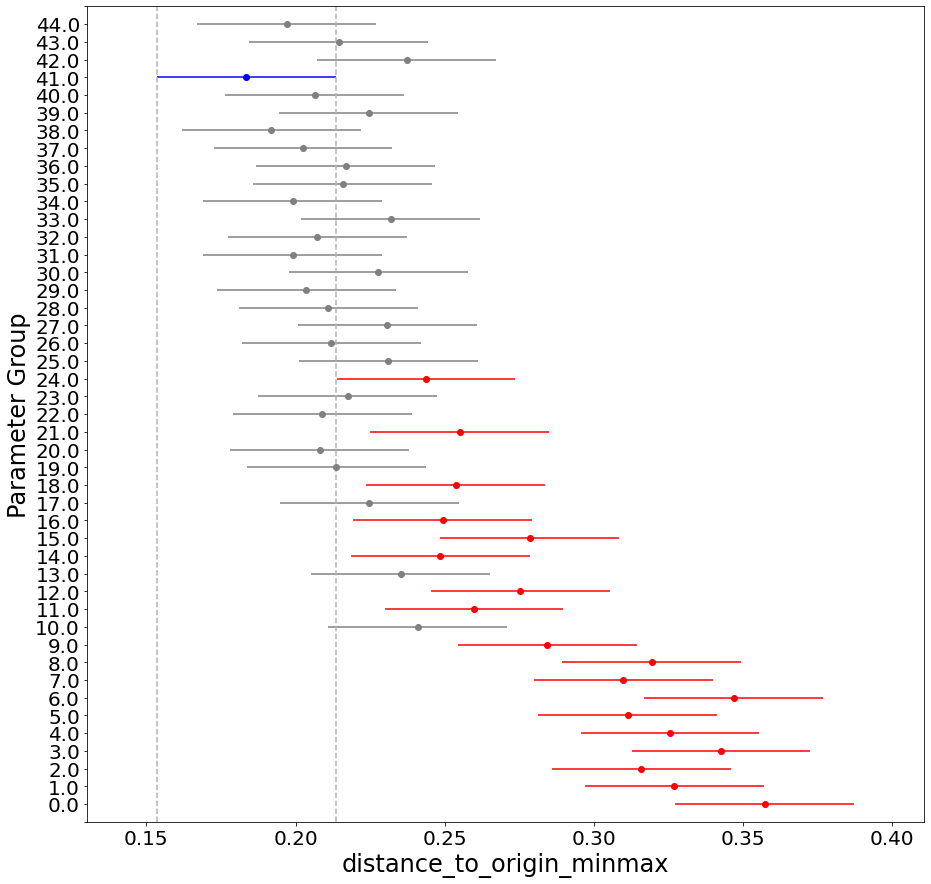

In [25]:
nsga2_data_tukey,fig,t = anova_plot2(NSGA2_data,'distance_to_origin_minmax','Parameter Group')

# NSGAIII

In [43]:
NSGA3_25_2 = pd.read_csv("parameter_data/UK25_2/NSGA3.csv")
NSGA3_25_4 = pd.read_csv("parameter_data/UK25_4/NSGA3.csv")
NSGA3_25_8 = pd.read_csv("parameter_data/UK25_8/NSGA3.csv")
NSGA3_50_1 = pd.read_csv("parameter_data/UK50_1/NSGA3.csv")
NSGA3_50_2 = pd.read_csv("parameter_data/UK50_2/NSGA3.csv")
NSGA3_50_4 = pd.read_csv("parameter_data/UK50_4/NSGA3.csv")
NSGA3_75_1 = pd.read_csv("parameter_data/UK75_1/NSGA3.csv")
NSGA3_75_3 = pd.read_csv("parameter_data/UK75_3/NSGA3.csv")
NSGA3_75_6 = pd.read_csv("parameter_data/UK75_6/NSGA3.csv")


NSGA3_25_2 = remove_unwanted_mutation_parameter_groups(NSGA3_25_2)
NSGA3_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_NSGA3 = [NSGA3_25_2,NSGA3_25_4,NSGA3_25_8,NSGA3_50_1,NSGA3_50_2,NSGA3_50_4,NSGA3_75_1,NSGA3_75_3,NSGA3_75_6]

for df in combined_NSGA3:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
NSGA3_data = pd.concat(combined_NSGA3)
    

In [47]:
NSGA3_data.groupby("Parameter Group").mean().sort_values(by=["distance_to_origin_minmax"]).head(10)

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax
Parameter Group,,,,,,,,,
40.0,14.5,229.965984,282.720000,0.9,0.50,20.0,367.720359,0.186301,0.147679
43.0,14.5,229.498304,283.666543,0.9,0.75,20.0,368.412861,0.177106,0.152840
44.0,14.5,228.836687,287.266420,0.9,0.75,30.0,371.029929,0.168467,0.166383
42.0,14.5,233.930140,284.420062,0.9,0.75,10.0,372.291787,0.192730,0.167591
39.0,14.5,232.132532,286.064012,0.9,0.50,10.0,372.274305,0.182304,0.167733
31.0,14.5,229.459844,286.899444,0.7,0.50,20.0,371.028089,0.176477,0.168072
41.0,14.5,230.411797,286.366235,0.9,0.50,30.0,371.368168,0.178688,0.169522
32.0,14.5,230.740285,286.715062,0.7,0.50,30.0,371.950269,0.176176,0.170961
35.0,14.5,229.984513,287.420123,0.7,0.75,30.0,372.103090,0.173053,0.173397


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



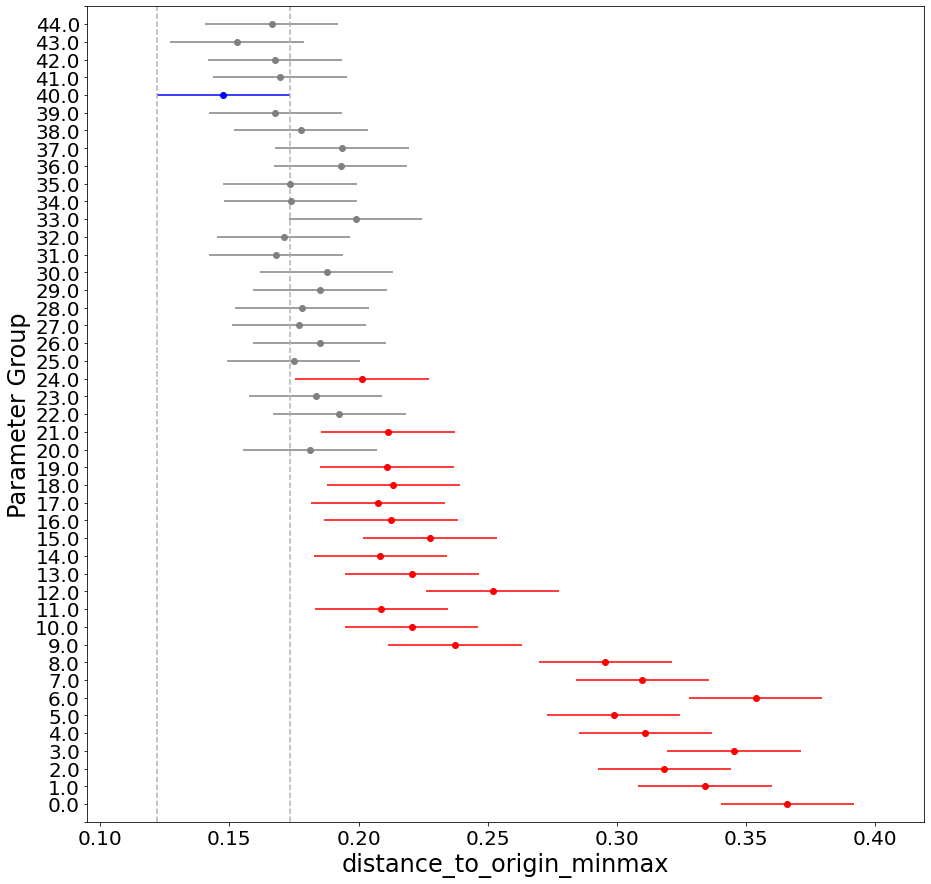

In [29]:
nsga3_data_tukey,fig,t = anova_plot2(NSGA3_data,'distance_to_origin_minmax','Parameter Group')

# UNSGAII

In [49]:
UNSGA3_25_2 = pd.read_csv("parameter_data/UK25_2/UNSGA3.csv")
UNSGA3_25_4 = pd.read_csv("parameter_data/UK25_4/UNSGA3.csv")
UNSGA3_25_8 = pd.read_csv("parameter_data/UK25_8/UNSGA3.csv")
UNSGA3_50_1 = pd.read_csv("parameter_data/UK50_1/UNSGA3.csv")
UNSGA3_50_2 = pd.read_csv("parameter_data/UK50_2/UNSGA3.csv")
UNSGA3_50_4 = pd.read_csv("parameter_data/UK50_4/UNSGA3.csv")
UNSGA3_75_1 = pd.read_csv("parameter_data/UK75_1/UNSGA3.csv")
UNSGA3_75_3 = pd.read_csv("parameter_data/UK75_3/UNSGA3.csv")
UNSGA3_75_6 = pd.read_csv("parameter_data/UK75_6/UNSGA3.csv")


UNSGA3_25_2 = remove_unwanted_mutation_parameter_groups(UNSGA3_25_2)
UNSGA3_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_UNSGA3 = [UNSGA3_25_2,UNSGA3_25_4,UNSGA3_25_8,UNSGA3_50_1,UNSGA3_50_2,UNSGA3_50_4,UNSGA3_75_1,UNSGA3_75_3,UNSGA3_75_6]

for df in combined_UNSGA3:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
UNSGA3_data = pd.concat(combined_UNSGA3)
    

In [50]:
UNSGA3_data.groupby("Parameter Group").mean().sort_values(by=["distance_to_origin_minmax"]).head(10)

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax
Parameter Group,,,,,,,,,
37.0,14.5,231.262232,286.036296,0.9,0.25,20.0,371.564680,0.191163,0.173687
35.0,14.5,230.086899,286.025926,0.7,0.75,30.0,370.828295,0.185734,0.176465
41.0,14.5,231.951863,285.334815,0.9,0.50,30.0,371.818205,0.191993,0.177304
31.0,14.5,231.226488,286.972531,0.7,0.50,20.0,372.225787,0.190910,0.177979
34.0,14.5,230.707029,286.221111,0.7,0.75,20.0,371.770659,0.181179,0.179640
44.0,14.5,230.641445,286.154691,0.9,0.75,30.0,371.552580,0.184275,0.181129
28.0,14.5,232.686623,286.785123,0.7,0.25,20.0,373.185715,0.195750,0.184778
23.0,14.5,235.145954,285.530000,0.5,0.50,30.0,373.770106,0.214232,0.185127
43.0,14.5,231.406382,288.144383,0.9,0.75,20.0,373.237437,0.193649,0.186048


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



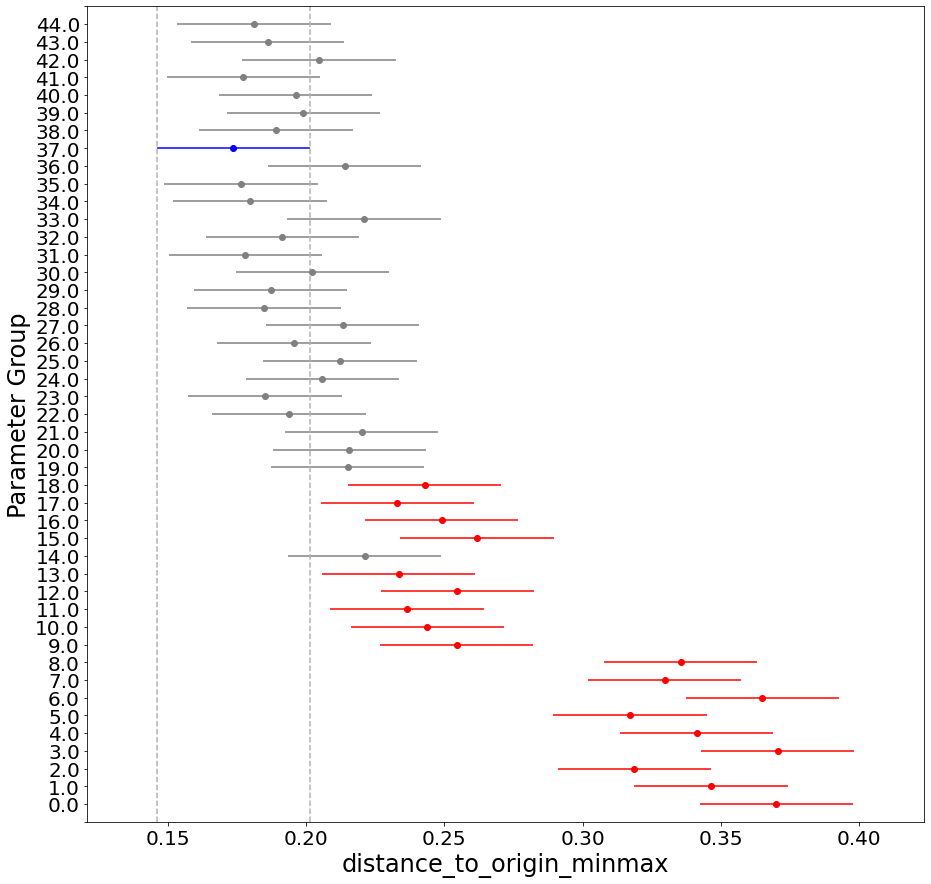

In [31]:
Unsga3_data_tukey,fig,t = anova_plot2(UNSGA3_data,'distance_to_origin_minmax','Parameter Group')

# IBEA

In [51]:
IBEA_25_2 = pd.read_csv("parameter_data/UK25_2/IBEA.csv")
IBEA_25_4 = pd.read_csv("parameter_data/UK25_4/IBEA.csv")
IBEA_25_8 = pd.read_csv("parameter_data/UK25_8/IBEA.csv")
IBEA_50_1 = pd.read_csv("parameter_data/UK50_1/IBEA.csv")
IBEA_50_2 = pd.read_csv("parameter_data/UK50_2/IBEA.csv")
IBEA_50_4 = pd.read_csv("parameter_data/UK50_4/IBEA.csv")
IBEA_75_1 = pd.read_csv("parameter_data/UK75_1/IBEA.csv")
IBEA_75_3 = pd.read_csv("parameter_data/UK75_3/IBEA.csv")
IBEA_75_6 = pd.read_csv("parameter_data/UK75_6/IBEA.csv")

IBEA_25_2 = remove_unwanted_mutation_parameter_groups(IBEA_25_2)
IBEA_25_2["Parameter Group"] =sorted(list(range(45)) * 30)
combined_IBEA = [IBEA_25_2,IBEA_25_4,IBEA_25_8,IBEA_50_1,IBEA_50_2,IBEA_50_4,IBEA_75_1,IBEA_75_3,IBEA_75_6]

for df in combined_IBEA:
    add_final_fitness_columns(df)
    expand_parameter_colums(df)
    add_distance_to_origin(df)
    
    max_fuel_consumption = max(df.fuel_consumption_final)
    min_fuel_consumption = min(df.fuel_consumption_final)
    df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)
    
    max_distance_to_origin = max(df.distance_to_origin)
    min_distance_to_origin = min(df.distance_to_origin)
    df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    
    
IBEA_data = pd.concat(combined_IBEA)
    

In [52]:
IBEA_data.groupby("Parameter Group").mean().sort_values(by=["distance_to_origin_minmax"]).head(10)

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin,fuel_consumption_final_minmax,distance_to_origin_minmax
Parameter Group,,,,,,,,,
43.0,14.5,229.187283,284.349938,0.9,0.75,20.0,369.301153,0.173010,0.166035
44.0,14.5,230.541552,282.854691,0.9,0.75,30.0,369.024022,0.180961,0.167253
28.0,14.5,234.910679,281.982901,0.7,0.25,20.0,371.246075,0.206906,0.173204
30.0,14.5,234.344479,282.979198,0.7,0.50,10.0,371.322153,0.208189,0.173474
32.0,14.5,230.204365,285.624568,0.7,0.50,30.0,370.651449,0.187897,0.174459
41.0,14.5,230.795966,285.712222,0.9,0.50,30.0,371.176132,0.185295,0.174890
42.0,14.5,231.464807,286.050802,0.9,0.75,10.0,372.066382,0.183512,0.176567
31.0,14.5,230.430322,285.011914,0.7,0.50,20.0,370.907986,0.178353,0.177840
25.0,14.5,231.358377,286.183827,0.5,0.75,20.0,371.942996,0.188903,0.179641


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



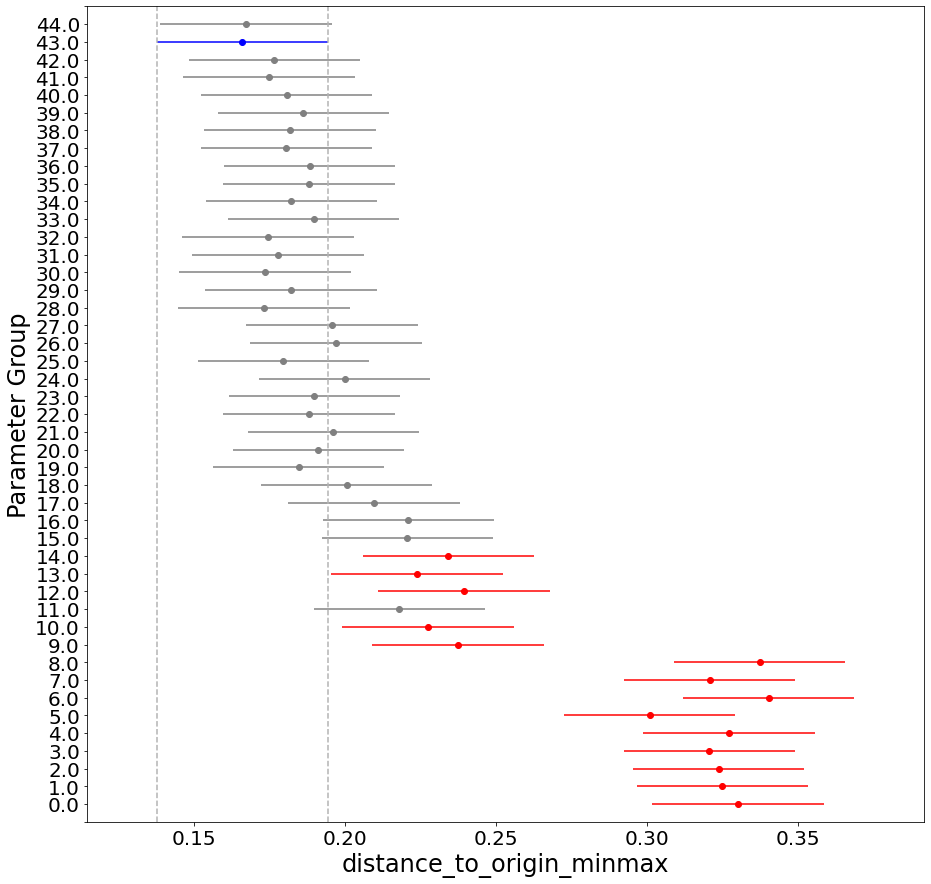

In [53]:
IBEA_data_tukey,fig,t = anova_plot2(IBEA_data,'distance_to_origin_minmax','Parameter Group')